# Assignment 1: Interpretability

In this assignment, we wil work on the model interpretability. First, we will implement LIME (Local interpretable model-agnostic explanations) and then explore SHAP (SHapley Additive exPlanations). Information about SHAP can be found [here](https://arxiv.org/abs/1705.07874).

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement and Test LIME


The aim of this assignment is to implement LIME using the information from the lecture and the publication. You should rely on the Inception V3 neural network. In addition, the focus would be on analysing the top 1 and top 2 predictions. The focus are images for this assignment. Superpixels are allowed to be used for making the task easier.
Note that you should not use an available LIME python-based library.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

### Inception_v3

**Also called GoogleNetv3, a famous ConvNet trained on ImageNet from 2015**
<center><img src="https://pytorch.org/assets/images/inception_v3.png" alt="alt" width="30%"/></center>

### Imports

In [2]:
import urllib
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import subprocess
import torch
import numpy as np
from skimage.segmentation import slic
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from collections import defaultdict

random.seed(47)  # Set random seed for reproducibility

c:\Users\ahmed\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


### Load Data

**Load Images**

In [3]:
image_url_list = ["https://upload.wikimedia.org/wikipedia/commons/2/2b/Schloss-Erlangen02.JPG",
                   "https://upload.wikimedia.org/wikipedia/commons/0/0c/Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG",
                   "https://upload.wikimedia.org/wikipedia/commons/c/cc/Alte-universitaets-bibliothek_universitaet-erlangen.jpg"]

img_file_path = "images/"
file_name_list = ["schloss.jpg", "burgberg.jpg", "bibliothek.jpg"]
file_path_list = [img_file_path + file_name for file_name in file_name_list]

In [4]:
def download_images(img_file_path, image_url_list):
    if os.path.exists(img_file_path) == False:
        os.makedirs(img_file_path)
    for url, filename in zip(image_url_list, file_path_list):
        try: urllib.URLopener().retrieve(url, filename)
        except: urllib.request.urlretrieve(url, filename)



download_images(img_file_path, image_url_list)

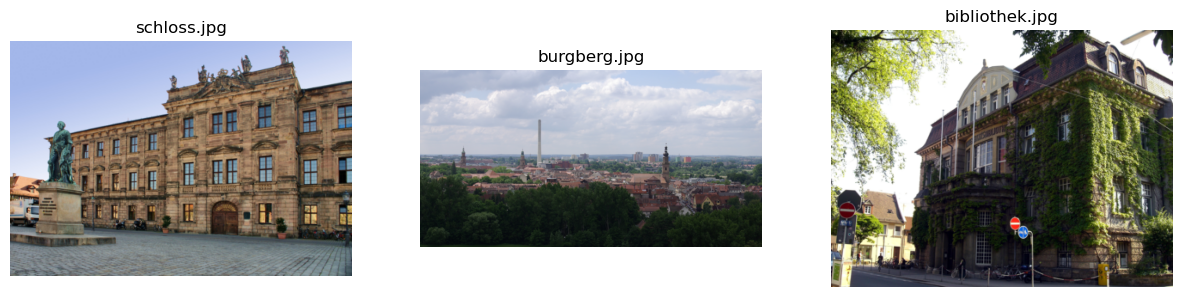

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
])

def load_images(file_path_list, preprocess=preprocess):
    images = []
    for filename in file_path_list:
        input_image = Image.open(filename)
        image = preprocess(input_image)
        images.append(image)
    return images


def visualize_images(images, file_name_list):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, image in enumerate(images):
        axs[i].imshow(image.permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(file_name_list[i])


images = load_images(file_path_list)
visualize_images(images, file_name_list)


**Load Inception v3 Labels**

In [6]:
def download_file(url, output_file):
    try:
        subprocess.run(["curl", "-o", output_file, url], check=True)
        print(f"Downloaded {url} to {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download {url}: {e}")
        raise

def read_categories(file_path):
    with open(file_path, "r") as f:
        categories = [s.strip() for s in f.readlines()]
    return categories

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
output_file = "imagenet_classes.txt"

download_file(url, output_file)
categories = read_categories(output_file)

print(categories[:10])


Downloaded https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt to imagenet_classes.txt
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']


### Load Inception v3 Model

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in C:\Users\ahmed/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\ahmed\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ahmed\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [8]:
def perturb_image_superpixels(image_tensor, num_perturbations=200, n_segments=25, compactness=10, sigma=1, min_segments=1, max_segments=5):
    """
    Perturbs the given image tensor using superpixels.
    """
    perturbed_images = []
    perturbed_images_indices = []
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    segments = slic(image_np, n_segments=n_segments, compactness=compactness, sigma=sigma)

    for _ in tqdm(range(num_perturbations)):
        list_length = random.randint(min_segments, max_segments)

        # Generate random numbers between 1 and n_segments
        random_numbers = [random.randint(1, n_segments) for _ in range(list_length)]

        # Create a mask for the perturbed segments
        perturbed_mask = np.isin(segments, random_numbers)
        negated_perturbed_mask = ~perturbed_mask
        
        # Perturb the selected segments by randomizing their colors
        perturbed_image_np = image_np.copy()
        perturbed_image_np[negated_perturbed_mask] = np.random.randint(0, 256, size=(3,))
        perturbed_images.append(torch.tensor(perturbed_image_np.transpose(2, 0, 1)))
        perturbed_images_indices.append(random_numbers)

    return torch.stack(perturbed_images), segments, perturbed_images_indices

In [9]:
def infer_with_model(input_tensor, model):
    """
    Perform inference using the given input tensor and model.
    """
    # Create a mini-batch as expected by the model: 3d to 4d
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    logits = output[0]

    return logits

In [10]:
def gaussian_kernel(similarity_scores, alpha):
    """
    Compute the Gaussian kernel weights for the similarity scores.
    """
    weights = np.exp(-alpha * (1 - similarity_scores.cpu().numpy()))
    return weights

def min_max_scaling(data):
    """
    Perform min-max scaling on the values of the input dictionary.
    """
    min_val = min(data.values())
    max_val = max(data.values())
    scaled_data = {key: (value - min_val) / (max_val - min_val) for key, value in data.items()}
    return scaled_data

In [11]:
def calculate_segment_weights(image_tensor, model, num_perturbations=200, n_segments=25, min_segments=2, max_segments=5, alpha=10):
    """
    Calculate the weights for the superpixels based on the cosine similarity between the original and perturbed logits.
    """
    perturbed_images_tensor, segments, perturbed_images_indices = perturb_image_superpixels(
        image_tensor, num_perturbations=num_perturbations, n_segments=n_segments, min_segments=min_segments, max_segments=max_segments)

    original_logits = infer_with_model(image_tensor, model)

    perturbed_logits = []
    for perturbed_image_tensor in perturbed_images_tensor:
        logits = infer_with_model(perturbed_image_tensor, model)
        perturbed_logits.append(logits)
    perturbed_logits = torch.stack(perturbed_logits)

    cos = torch.nn.CosineSimilarity(dim=1)
    cos_sim = cos(original_logits, perturbed_logits)

    weights = gaussian_kernel(cos_sim, alpha)

    segment_weights = defaultdict(list)

    for i, indices in enumerate(perturbed_images_indices): 
        for index in indices:
            segment_weights[index].append(weights[i])

    # Normalize the weights
    for key in segment_weights:
        segment_weights[key] = sum(segment_weights[key]) / len(segment_weights[key])

    # sort dict by key name
    segment_weights = dict(sorted(segment_weights.items()))
    
    return segment_weights, segments, cos_sim, perturbed_images_tensor


  0%|          | 0/200 [00:00<?, ?it/s]

c:\Users\ahmed\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

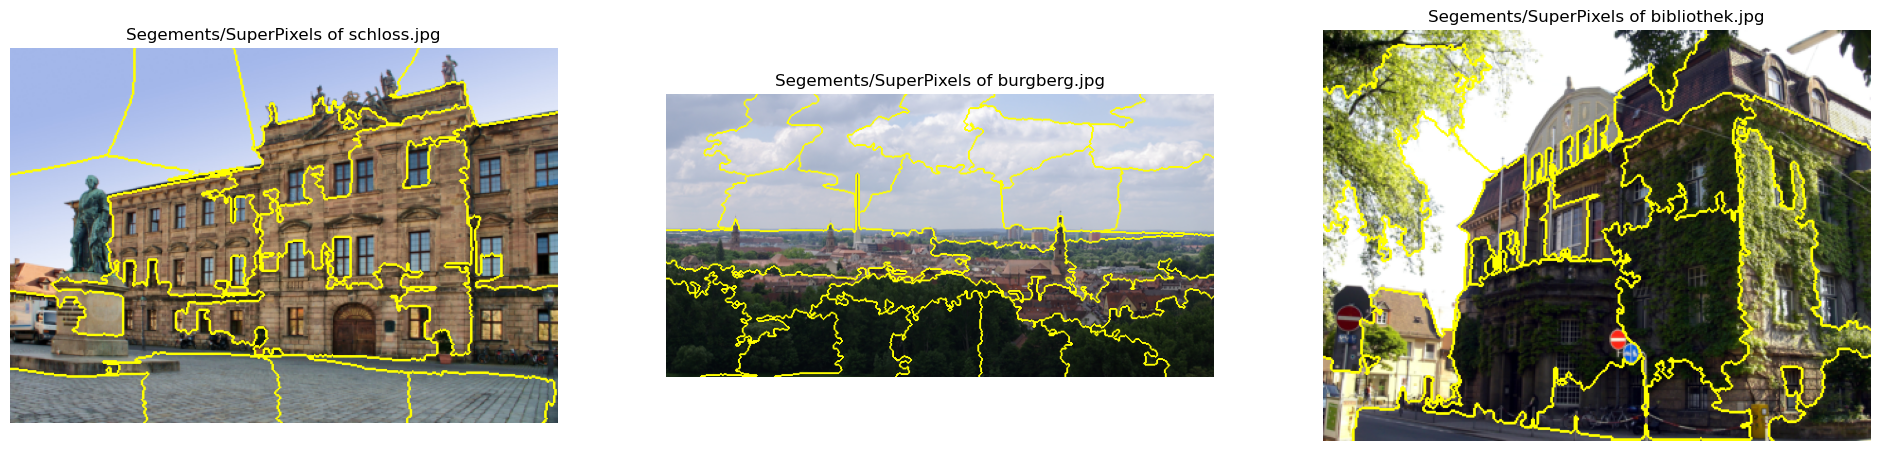

In [12]:
def visualize_segments(image_tensor, segments, segment_weights, scale_weights=False):
    """
    Visualize the superpixels with their respective weights.
    """
    if scale_weights:
        segment_weights = min_max_scaling(segment_weights)

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    return image_np, segments, segment_weights

# visualize the segments
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

for idx, image_tensor in enumerate(images):
    _, segments, *_ = calculate_segment_weights(image_tensor, model)
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    axs[idx].imshow(mark_boundaries(image_np, segments, color=(1, 1, 0))) # yellow
    axs[idx].set_title(f'Segements/SuperPixels of {file_name_list[idx]}')
    axs[idx].axis('off')

**Without Scaling**

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

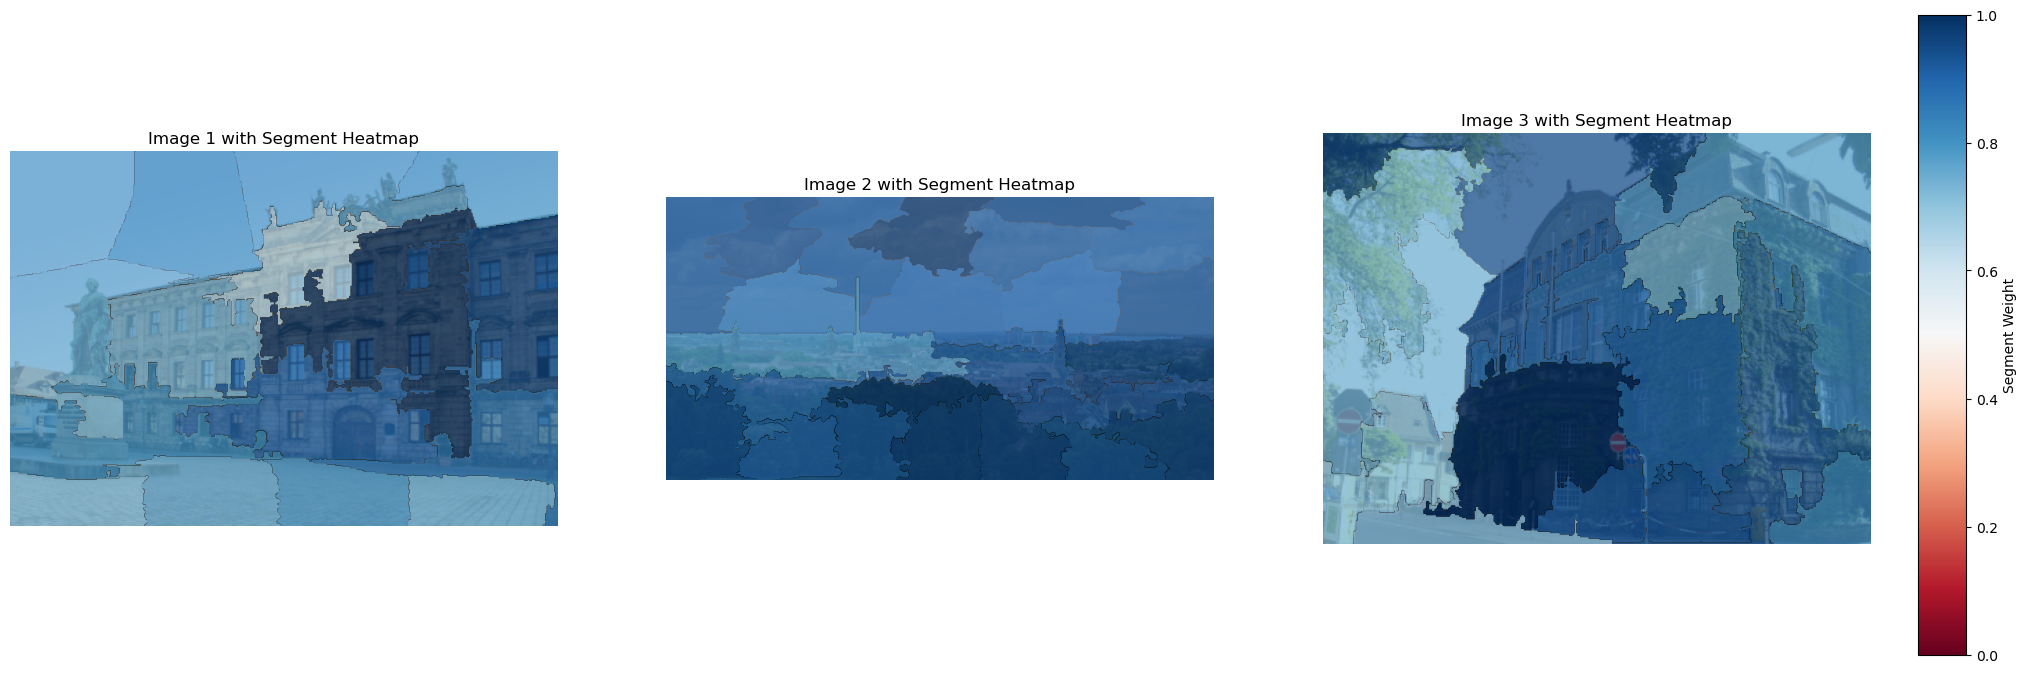

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
all_perturbed_images = []
all_cos_sim = []
for idx, image_tensor in enumerate(images):
    segment_weights, segments, cos_sim, perturbed_images_tensor = calculate_segment_weights(image_tensor, model)
    all_cos_sim.append(cos_sim)
    all_perturbed_images.append(perturbed_images_tensor)
    image_np, segments, segment_weights = visualize_segments(image_tensor, segments, segment_weights, scale_weights=False)
    axs[idx].imshow(image_np)
    axs[idx].axis('off')

    # color weights
    segment_colors = [segment_weights.get(segment_id, 0) for segment_id in np.unique(segments)]
    segment_colors = np.array(segment_colors) / np.max(list(segment_weights.values()))

    for segment_id in np.unique(segments):
        mask = (segments == segment_id)
        color = plt.cm.RdBu(segment_colors[np.where(np.unique(segments) == segment_id)[0][0]])
        axs[idx].imshow(color * mask[..., None], alpha=0.75)  # Overlay colored segments with transparency

    axs[idx].set_title(f'Image {idx + 1} with Segment Heatmap')

cax = plt.axes([0.92, 0.1, 0.02, 0.8])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdBu), cax=cax)
cbar.set_label('Segment Weight')

plt.show()


**With MinMax Scaler**

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

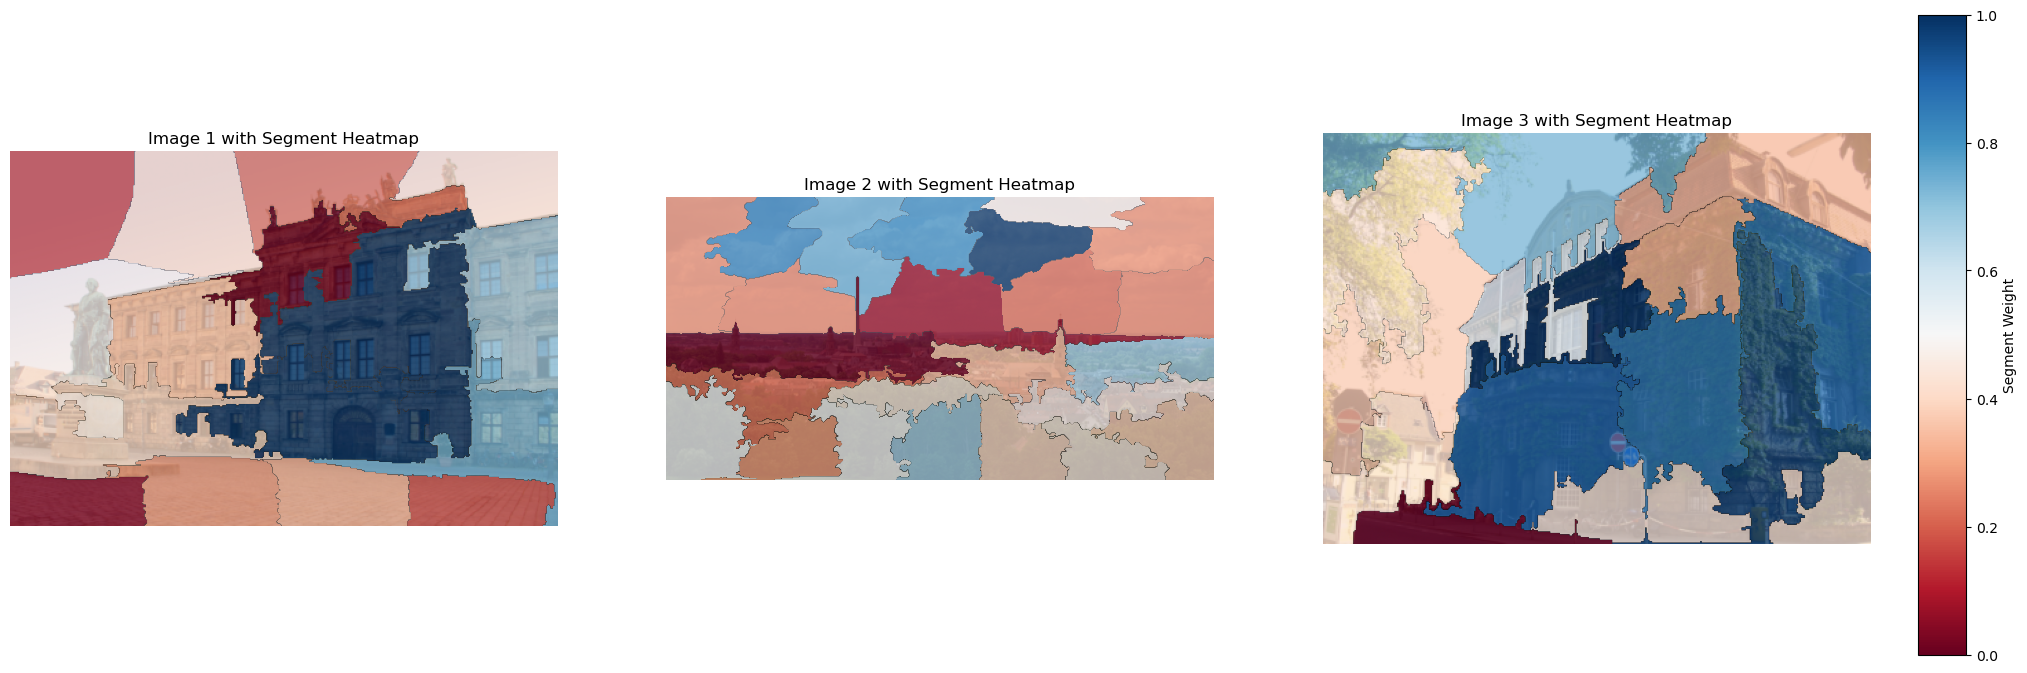

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
for idx, image_tensor in enumerate(images):
    segment_weights, segments, cos_sim, perturbed_images_tensor = calculate_segment_weights(image_tensor, model)
    image_np, segments, segment_weights = visualize_segments(image_tensor, segments, segment_weights, scale_weights=True)
    axs[idx].imshow(image_np)
    axs[idx].axis('off')

    # color weights
    segment_colors = [segment_weights.get(segment_id, 0) for segment_id in np.unique(segments)]
    segment_colors = np.array(segment_colors) / np.max(list(segment_weights.values()))

    for segment_id in np.unique(segments):
        mask = (segments == segment_id)
        color = plt.cm.RdBu(segment_colors[np.where(np.unique(segments) == segment_id)[0][0]])
        axs[idx].imshow(color * mask[..., None], alpha=0.75) 

    axs[idx].set_title(f'Image {idx + 1} with Segment Heatmap')

cax = plt.axes([0.92, 0.1, 0.02, 0.8])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdBu), cax=cax)
cbar.set_label('Segment Weight')

plt.show()


**Most Similar Segments**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 3 similar images for schloss.jpg:
tensor([0.0183, 0.0179, 0.0128], device='cuda:0')


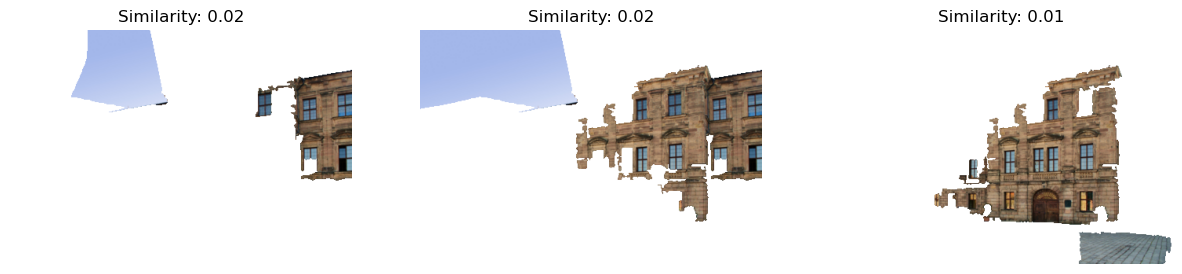

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 3 similar images for burgberg.jpg:
tensor([0.0184, 0.0129, 0.0050], device='cuda:0')


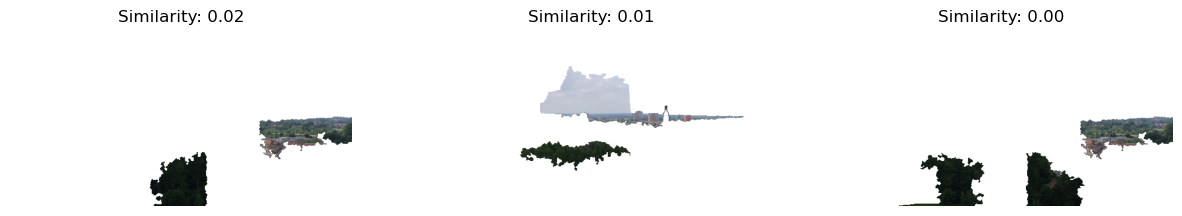

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 3 similar images for bibliothek.jpg:
tensor([0.0293, 0.0252, 0.0148], device='cuda:0')


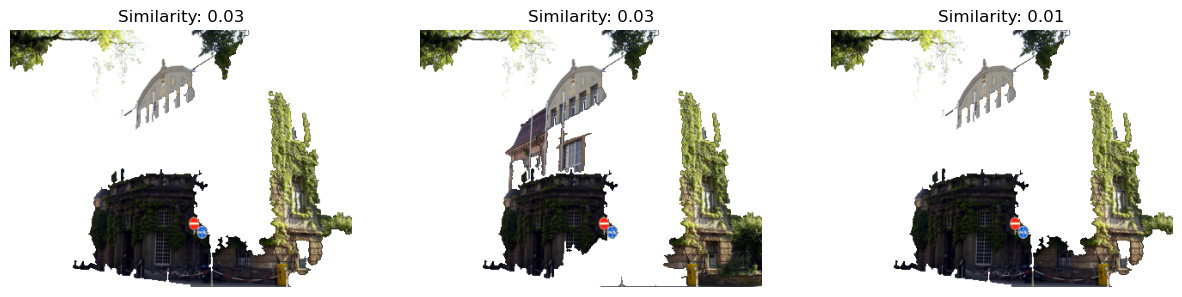

In [15]:
for idx, cos_sim in enumerate(all_cos_sim):
    top_values, top_indices = torch.topk(cos_sim, k=3)
    print(f"Top 3 similar images for {file_name_list[idx]}:")
    print(top_values)
    
    # plot the top 3 similar images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(all_perturbed_images[idx][top_indices[i]].permute(1, 2, 0))
        ax.set_title(f"Similarity: {top_values[i]:.2f}")
        ax.axis("off")
    plt.show()

## 2. Test SHAP

For the same images, you should now use the SHAP algorithm to provide visual explanations. In this case, you do not need to implement the algorithm. Instead, you could use an existing Python library such as [SHAP](https://shap.readthedocs.io/en/latest/image_examples.html). ResNet 50 is a good reference for running the tests. Inception V3 can also be used. For this task, [TensorFlow](https://www.tensorflow.org) can be used as well.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

![](https://shap.readthedocs.io/en/latest/_images/example_notebooks_image_examples_image_classification_Explain_ResNet50_using_the_Partition_explainer_10_0.png)

In [16]:
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import shap
from PIL import Image
import numpy as np

In [17]:
X = [Image.open(file_name).resize((224, 224)) for file_name in file_path_list]
X = [np.array(img) for img in X]
X = np.array(X)
X.shape

(3, 224, 224, 3)

In [18]:
model = ResNet50(weights="imagenet")

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [19]:
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)


masker = shap.maskers.Image("inpaint_telea", X[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.36s/it]               


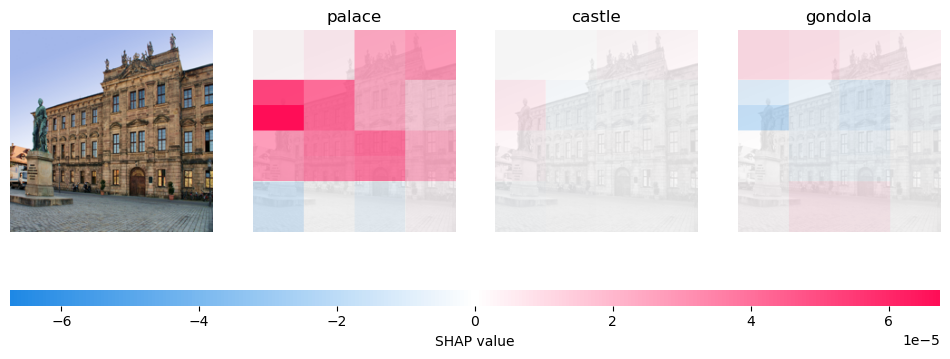

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
palace: 93.39%
castle: 2.40%
gondola: 1.39%



  0%|          | 0/98 [00:00<?, ?it/s]

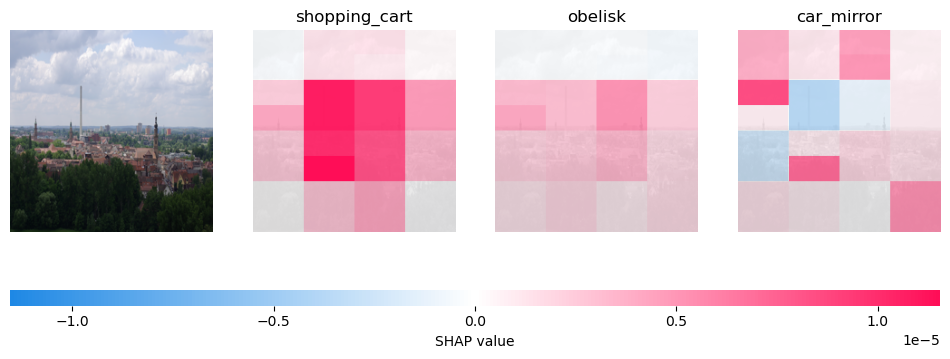

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
shopping_cart: 19.01%
obelisk: 8.30%
car_mirror: 7.01%



  0%|          | 0/98 [00:00<?, ?it/s]

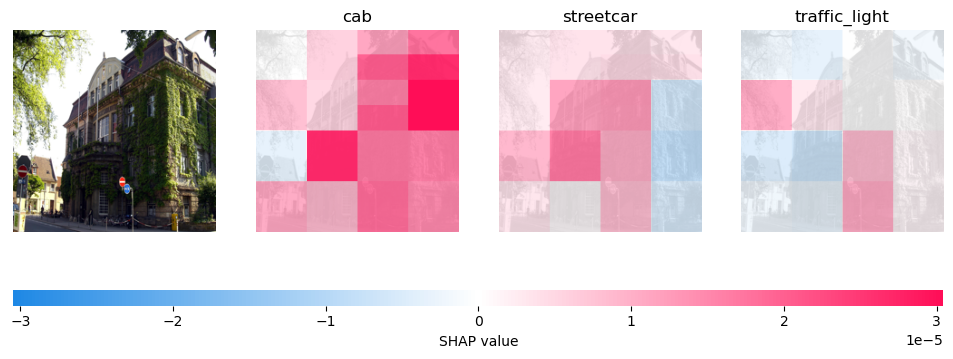

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
cab: 65.41%
streetcar: 21.01%
traffic_light: 3.10%



In [20]:
TOP_N = 3

for i in range(len(X)):
    shap_values = explainer(X[i:i+1], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:TOP_N])
    shap.image_plot(shap_values)
    
    # infer model predictions
    preds = model.predict(X[i:i+1])
    
    # decode the predictions
    preds_decoded = decode_predictions(preds, top=TOP_N)[0]
    
    for pred in preds_decoded:
        class_id, class_name, score = pred
        print(f"{class_name}: {score*100:.2f}%")
    print()
    
